In [49]:
!pip install gql requests chord

     |████████████████████████████████| 75 kB 964 kB/s eta 0:00:011
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6500 sha256=0320fe030ac29a88ccbdf095d08beadc690e59529dca4f8735aea5e98e9acc65
  Stored in directory: /Users/rpetry/Library/Caches/pip/wheels/20/18/ca/566a05e0cb4865f6a264a809b207181ef5cc5f32b26c4c41c6
Successfully built uuid
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.6/bin/python3.6 -m pip install --upgrade pip' command.


In [2]:
import requests
from IPython.display import display, Markdown
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

_transport = RequestsHTTPTransport(
    url='https://api.datacite.org/graphql',
    use_json=True,
)


client = Client(
    transport=_transport,
    fetch_schema_from_transport=True,
)

In [99]:
# Generate the GraphQL query: find all outputs FREYA project (https://cordis.europa.eu/project/id/777523) to date
query_params = {
    "funderId" : "https://doi.org/10.13039/501100000780",
    "funderAwardQuery" : "fundingReferences.awardNumber:777523",
    "maxWorks" : 75
}

query = gql("""query getGrantOutputsForFunderAndAward($funderId: ID!, $funderAwardQuery: String!, $maxWorks: Int!)
{
funder(id: $funderId) {
  name
  works(query: $funderAwardQuery, first: $maxWorks) {
      totalCount
      nodes {
        id
        formattedCitation(style: "vancouver")
        titles {
          title
        }
        descriptions {
          description
        }        
        types {
          resourceType
        }
        dates {
          date
          dateType
        }
        versionOfCount
        creators {
          id
          name
        }
        fundingReferences {
          funderIdentifier
          funderName
          awardNumber
          awardTitle
        }
        citationCount
        viewCount
        downloadCount
      }
    }
  }
}
""")

In [100]:
import json
data = client.execute(query, variable_values=json.dumps(query_params))

In [101]:
# Get the total number of outputs to date
funder = data['funder']['works']
display(Markdown(str(funder['totalCount'])))

69

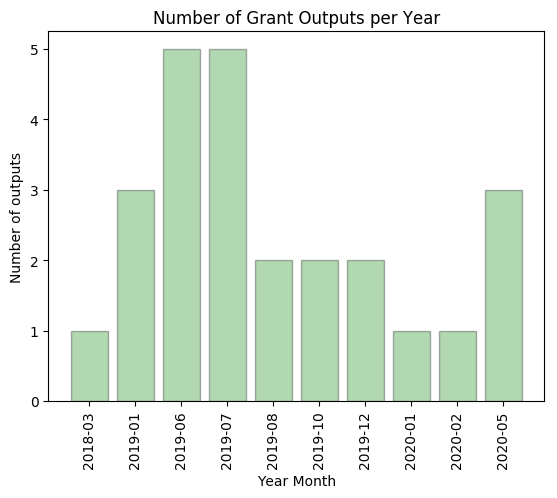

In [102]:
# Plot the total number of outputs to date, by year
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np

plt.rcdefaults()

# Retrieve works counts by month-year from nodes
# Pick out date of type: 'Issued'; failing that use 'Created' date.
num_outputs_dict = {}
for r in funder['nodes']:
    node_date = None
    for date_dict in r['dates']:
        ym = '-'.join(date_dict['date'].split('-')[0:2])
        if node_date is None:
            if date_dict['dateType'] in ['Issued', 'Created']:
                node_date = ym
        else:
            if date_dict['dateType'] in ['Issued']:
                node_date = ym
    if ym not in num_outputs_dict:
        num_outputs_dict[node_date] = 0
    num_outputs_dict[node_date] += 1;
    
# Sort works counts by month-year in chronological order
year_months = []
num_outputs = []
for ym in sorted(list(num_outputs_dict.keys())):
    year_months.append(ym)
    num_outputs.append(num_outputs_dict[ym])
        
# Generate a plot of number of grant outputs by year - month
fig, ax = plt.subplots()
x_pos = np.arange(len(year_months))
ax.bar(x_pos, num_outputs, align='center', color='green', edgecolor='black', linewidth=1, alpha=0.3)
ax.set_xticks(x_pos)
ax.set_xticklabels(year_months, rotation='vertical')
ax.set_ylabel('Number of outputs')
ax.set_xlabel('Year Month')
ax.set_title('Number of Grant Outputs per Year')
plt.show()


In [103]:
from IPython.core.display import display, HTML
xstr = lambda s: '' if s is None else str(s)

# Get details for each output
outputs = [['ID','Type','Titles','Creators','Funders','Award Numbers','Award Titles']]
# Since there is scope for duplicates in Zenodo, versions of previously seen nodes are considered duplicates and stored in duplicate_versions so that 
# they can be excluded if seen later
unique_output_nodes = []
for r in funder['nodes']:
    id = '<a href="%s">%s</a></html>' % (r['id'], '/'.join(r['id'].split("/")[3:]))
    if r['versionOfCount'] > 0:
        # If the current output is a version of another one, exclude it
        continue
    # Store unique output nodes - to be used downstream in this notebook
    unique_output_nodes.append(r)
    
    titles = '; '.join([s['title'] for s in r['titles']])
    creators = '; '.join(['<a href="%s">%s</a>' % (s['id'],s['name']) for s in r['creators']])
    resource_type = xstr(r['types']['resourceType'])
    funders = '; '.join(set(['<a href="%s">%s</a>' % (s['funderIdentifier'],s['funderName']) for s in r['fundingReferences']]))
    award_numbers = '; '.join([s['awardNumber'] for s in r['fundingReferences']])
    award_titles = '; '.join([s['awardTitle'] for s in r['fundingReferences']])
    output = [id, resource_type, titles, creators, funders, award_numbers, award_titles]
    outputs += [output]
    
# Display outputs as html table 
html_table = '<html><table>'   
html_table += '<tr><th style="text-align:center;">' + '</th><th style="text-align:center;">'.join(outputs[0]) + '</th></tr>'
for row in outputs[1:]:
    html_table += '<tr><td style="text-align:left;">' + '</td><td style="text-align:left;">'.join(row) + '</td></tr>'
html_table += '</table></html>'
display(HTML(html_table))

ID,Type,Titles,Creators,Funders,Award Numbers,Award Titles
10.5281/zenodo.1263942,,Listing of data repositories that embed schema.org metadata in dataset landing pages,"Fenner, Martin; Crosas, Merce; Durand, Gustavo; Wimalaratne, Sarala; Gräf, Florian; Hallett, Richard; Bernal Llinares, Manuel; Schindler, Uwe; Clark, Tim",European Commission,777523,"Connected Open Identifiers for Discovery, Access and Use of Research Resources"
10.5281/zenodo.3361511,Presentation,RDA Europe Update,"Brown, Christopher",European Commission,777523; 777388,"Connected Open Identifiers for Discovery, Access and Use of Research Resources; The European plug-in to the global Research Data Alliance"
10.5281/zenodo.3361398,Presentation,JISC and PIDs,"Brown, Christopher",European Commission,777523; 777388,"Connected Open Identifiers for Discovery, Access and Use of Research Resources; The European plug-in to the global Research Data Alliance"
10.5281/zenodo.3248652,Project deliverable,D2.2 PID Metadata Provenance,"Fenner, Martin; Wass, Joe; Demeranville, Tom; Wimalaratne, Sarala; Hallett, Richard",European Commission,777523,"Connected Open Identifiers for Discovery, Access and Use of Research Resources"
10.14454/3bpw-w381,Jupyter Notebook,Jupyter Notebook FREYA PID Graph Key Performance Indicators (KPIs),"Fenner, Martin",European Commission,777523,"Connected Open Identifiers for Discovery, Access and Use of Research Resources"
10.5281/zenodo.2549228,Presentation,From Standard to Community Resource: A View on ISNIs and ORG IDs,"Reimer, Torsten; Madden, Frances",European Commission,777523,"Connected Open Identifiers for Discovery, Access and Use of Research Resources"
10.5281/zenodo.3564209,Presentation,(Effectively) Communicating your research online presentations,"Morselli, Francesca; Madden, Frances; Burton, Kath; Blaney, Jonathan",European Commission,777523,"Connected Open Identifiers for Discovery, Access and Use of Research Resources"
10.5281/zenodo.3462140,Project deliverable,Deliverable 5.4 Initial Training Materials,"Madden, Frances; Mayville, Louise; Cousijn, Helena; Horik, René Van; Kotarski, Rachael",European Commission,777523,"Connected Open Identifiers for Discovery, Access and Use of Research Resources"
10.5281/zenodo.3361404,Presentation,RDA Open Science Graphs for FAIR Data Interest Group,"Fenner, Martin",European Commission,777523; 777388,"Connected Open Identifiers for Discovery, Access and Use of Research Resources; The European plug-in to the global Research Data Alliance"
10.5281/zenodo.3248653,Project deliverable,D2.2 PID Metadata Provenance,"Fenner, Martin; Wass, Joe; Demeranville, Tom; Wimalaratne, Sarala; Hallett, Richard",European Commission,777523,"Connected Open Identifiers for Discovery, Access and Use of Research Resources"


In [104]:
from IPython.core.display import display, HTML

# Get bibtex entry for each output
outputs = [['ID','Formatted Citation', 'Descriptions', 'Number of Citations', 'Number of Views', 'Number of Downloads' ]]
for r in unique_output_nodes:
    id = '<a href="%s">%s</a></html>' % (r['id'], '/'.join(r['id'].split("/")[3:]))
    formattedCitation = r['formattedCitation']
    descriptions = '; '.join([s['description'] for s in r['descriptions']])
    output = [id, formattedCitation, descriptions, str(r['citationCount']), str(r['viewCount']), str(r['downloadCount'])]
    outputs += [output]
    
# Display outputs as html table 

html_table = '<html><table>'   
html_table += '<tr><th style="text-align:center;">' + '</th><th style="text-align:center;">'.join(outputs[0]) + '</th></tr>'
for row in outputs[1:]:
    html_table += '<tr><td style="text-align:left;">' + '</td><td style="text-align:left;">'.join(row) + '</td></tr>'
html_table += '</table></html>'
display(HTML(html_table))

ID,Formatted Citation,Descriptions,Number of Citations,Number of Views,Number of Downloads
10.5281/zenodo.1263942,"Fenner M, Crosas M, Durand G, Wimalaratne S, Gräf F, Hallett R, et al. Listing of data repositories that embed schema.org metadata in dataset landing pages [Internet]. Zenodo; 2018. Available from: https://zenodo.org/record/1263942","Machine-readable metadata available from landing pages for datasets facilitate data citation by enabling easy integration with reference managers and other tools used in a data citation workflow. Embedding these metadata using the schema.org standard with the JSON-LD is emerging as the community standard. This dataset is a listing of data repositories that have implemented this approach or are in the progress of doing so. This is the first version of this dataset and was generated via community consultation. We expect to update this dataset, as an increasing number of data repositories adopt this approach, and we hope to see this information added to registries of data repositories such as re3data and FAIRsharing. In addition to the listing of data repositories we provide information of the schema.org properties supported by these data repositories, focussing on the required and recommended properties from the ""Data Citation Roadmap for Scholarly Data Repositories"".",1,0,0
10.5281/zenodo.3361511,Brown C. RDA Europe Update. 2019Jul16; Available from: https://zenodo.org/record/3361511,Update presentation on the activities of RDA Europe from the RDA UK FREYA workshop on 16 July 2019.,0,0,0
10.5281/zenodo.3361398,Brown C. JISC and PIDs. 2019Jul16; Available from: https://zenodo.org/record/3361398,Presentation outlining JISC's work relating to different persistent identifiers. Presented at the joint FREYA RDA UK Node Workshop 16 July 2019.,0,0,0
10.5281/zenodo.3248652,"Fenner M, Wass J, Demeranville T, Wimalaratne S, Hallett R. D2.2 PID Metadata Provenance. 2019Jun18; Available from: https://zenodo.org/record/3248652","The main focus of this document is describing the implementations of provenance tracking by the persistent identifier (PID) providers Crossref, ORCID, Identifiers.org (EMBL-EBI), and DataCite in the FREYA project. We describe the implementations by Crossref and ORCID done previously, the DataCite implementation done as main output for this deliverable, and the conceptual work by identifiers.org. The FREYA project has received funding from the European Union's Horizon 2020 research and innovation programme under grant agreement No 777523",1,0,0
10.14454/3bpw-w381,Fenner M. Jupyter Notebook FREYA PID Graph Key Performance Indicators (KPIs) [Internet]. DataCite; 2019. Available from: https://github.com/datacite/pidgraph-notebooks-r/tree/master/kpi,,0,0,0
10.5281/zenodo.2549228,"Reimer T, Madden F. From Standard to Community Resource: A View on ISNIs and ORG IDs. 2019Jan25; Available from: https://zenodo.org/record/2549228","Over the last year, the International Standard Name Identifier board have been considering the ways in which ISNI as a system can improve to meet new challenges and become more open and transparent. One particular consideration has been to make ISNIs a better solution for organisation identifiers. The British Library as an ISNI Registration Agency has also been developing tools that make it easier to use for identifying organisations, in response to feedback from national and international collaborators. This session will give PIDapalooza an update on ISNI and British Library activities over the past year and demonstrate how we are working to get a wider buy-in on persistent identification of organisations early on – including how we’re attempting to work with funders to embed PID practice.",0,0,0
10.5281/zenodo.3564209,"Morselli F, Madden F, Burton K, Blaney J. (Effectively) Communicating your research online presentations. 2019Dec5; Available from: https://zenodo.org/record/3564209","Presentations from the event (Effectively) Communicating your research 

In [105]:
# Generate a Chord plot representing co-authorship relationships across all grant award outputs
from chord import Chord

all_creator_names_by_node = []
all_creator_names_set = set([])
for r in unique_output_nodes:
    creator_names = [s['name'] for s in r['creators']]
    all_creator_names_by_node.append(creator_names)
    all_creator_names_set.update(creator_names)
    
# Assemble data structures for the co-authorship chord diagram
all_creator_names = sorted(list(all_creator_names_set))

# Initialise chord data matrix
length = len(all_creator_names)
coauthorship_matrix = []
for i in range(length):
    r = []
    for j in range(length):
        r.append(0)
    coauthorship_matrix.append(r)
    
# Populate chord data matrix
for node_creators in all_creator_names_by_node:
    for creator in node_creators:
        c_pos = all_creator_names.index(creator)
        for co_creator in node_creators:
            co_pos = all_creator_names.index(co_creator)
            if c_pos != co_pos:
                coauthorship_matrix[c_pos][co_pos] += 1

# display co-authorship cord diagram
Chord(coauthorship_matrix, all_creator_names, wrap_labels=False, margin=180).show()